In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing Datasets

In [24]:
data = pd.read_excel('Nifty series Value and PE Ratio.xlsx')
print(data)

           Date  Nifty Value  PE Ratio
0    2000-07-05      1526.05   19.7303
1    2000-07-06      1516.80   19.6107
2    2000-07-07      1517.60   19.6210
3    2000-07-10      1509.65   19.5182
4    2000-07-11      1518.55   19.6333
...         ...          ...       ...
5187 2021-05-12     14696.50   31.6548
5188 2021-05-14     14677.80   31.6145
5189 2021-05-17     14808.90   31.6145
5190        NaT          NaN   31.6145
5191        NaT          NaN   31.8922

[5192 rows x 3 columns]


## Creating_Month_End_Database

In [29]:
def find_unique_months(df):
  df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
  pp = pd.DataFrame()
  pp['max_date'] = ( df.groupby([df['Date'].dt.year, df['Date'].dt.month])['Date'].transform('max'))
  df = pd.DataFrame(pp.max_date.unique(), columns =['Date'])
  return df

In [30]:
month_end_dates = find_unique_months(data)
month_end_dates.dropna(inplace = True)
month_end_dates

,Date
0,2000-07-31
1,2000-08-31
2,2000-09-29
3,2000-10-31
4,2000-11-30
...,...
246,2021-01-29
247,2021-02-26
248,2021-03-31
249,2021-04-30


In [31]:
monthly_data = month_end_dates.merge(data, on='Date', how='inner')# joing to dataframe (vlookup)
monthly_data

,Date,Nifty Value,PE Ratio
0,2000-07-31,1332.85,17.2324
1,2000-08-31,1394.10,18.5937
2,2000-09-29,1271.65,16.9605
3,2000-10-31,1172.75,15.5767
4,2000-11-30,1268.15,17.6839
...,...,...,...
246,2021-01-29,13634.60,32.4338
247,2021-02-26,14529.15,34.5618
248,2021-03-31,14690.70,31.6548
249,2021-04-30,14631.10,31.5140


# Simple Systematic Withdrawal Plan (SSWP)

### Basic Assumptions:
1. Only NIFTY values have been considered as the NAV values for finding out the monthly residual corpus. 
2. The increase/decrease in the residual corpus will be in proportion to %incease /decrease of NIFTY values

In [32]:
monthly_data['10_years_%_Change'] = monthly_data['Nifty Value'].pct_change(10*12)
monthly_data['monthly_%_Change'] = monthly_data['Nifty Value'].pct_change()

In [33]:
def SSWP_Calc_monthly(df, principal, interest_rate):
  initial_corpus = principal
  monthly_outflow = (principal*interest_rate) / 1200
  for i in range(1, len(df)):
    b = ((initial_corpus*(1+ df.loc[i, 'monthly_%_Change'])))- monthly_outflow
    c = ((initial_corpus*(df.loc[i, 'monthly_%_Change'])))+ monthly_outflow
    df.loc[(i),'Residual_Corpus_monthly'] = ((initial_corpus*(1+ df.loc[i, 'monthly_%_Change'])))- monthly_outflow
    df.loc[(i),'Monthly_Netflow'] = ((initial_corpus*(df.loc[i, 'monthly_%_Change']))) + monthly_outflow
    initial_corpus = b 
    df['Cummulative_Inflow'] = df['Monthly_Netflow'].cumsum()
  return df

In [34]:
def SSWP_Calc_10_years(df, principal, interest_rate):
  initial_corpus = principal
  ten_year_outflow = (principal*interest_rate) /10
  for i, j in df.iterrows():
    df.loc[i,'Residual_Corpus_10_years'] = (initial_corpus - ten_year_outflow) + (initial_corpus * df.loc[i, '10_years_%_Change'])
  return df

In [35]:
def IRR_calculation(df, principal):
  monthly_data_new = df.iloc[120:]
  import math
  for i, k in monthly_data_new.iterrows():
    l = monthly_data_new.loc[i,'Residual_Corpus_10_years']
    m = 0.1 * (math.log((monthly_data_new.loc[i,'Residual_Corpus_10_years'])/(principal)))
    monthly_data_new.loc[i,'IRR'] = ((10**m)-1)*100
  return monthly_data_new


In [36]:
SSWP_Calc_monthly(monthly_data, 10**7, 6)

,Date,Nifty Value,PE Ratio,10_years_%_Change,monthly_%_Change,Residual_Corpus_monthly,Monthly_Netflow,Cummulative_Inflow
0,2000-07-31,1332.85,17.2324,NaN,NaN,NaN,NaN,NaN
1,2000-08-31,1394.10,18.5937,NaN,0.045954,1.040954e+07,5.095416e+05,5.095416e+05
2,2000-09-29,1271.65,16.9605,NaN,-0.087834,9.445225e+06,-8.643163e+05,-3.547747e+05
3,2000-10-31,1172.75,15.5767,NaN,-0.077773,8.660642e+06,-6.845832e+05,-1.039358e+06
4,2000-11-30,1268.15,17.6839,NaN,0.081347,9.315162e+06,7.545195e+05,-2.848385e+05
...,...,...,...,...,...,...,...,...
246,2021-01-29,13634.60,32.4338,1.476362,-0.024829,4.875421e+07,-1.192602e+06,6.335421e+07
247,2021-02-26,14529.15,34.5618,1.724258,0.065609,5.190292e+07,3.248706e+06,6.660292e+07
248,2021-03-31,14690.70,31.6548,1.518226,0.011119,5.243003e+07,6.271099e+05,6.723003e+07
249,2021-04-30,14631.10,31.5140,1.544760,-0.004057,5.216732e+07,-1.627080e+05,6.706732e+07


In [37]:
SSWP_Calc_10_years(monthly_data, 10**7, 6)

,Date,Nifty Value,PE Ratio,10_years_%_Change,monthly_%_Change,Residual_Corpus_monthly,Monthly_Netflow,Cummulative_Inflow,Residual_Corpus_10_years
0,2000-07-31,1332.85,17.2324,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-31,1394.10,18.5937,NaN,0.045954,1.040954e+07,5.095416e+05,5.095416e+05,NaN
2,2000-09-29,1271.65,16.9605,NaN,-0.087834,9.445225e+06,-8.643163e+05,-3.547747e+05,NaN
3,2000-10-31,1172.75,15.5767,NaN,-0.077773,8.660642e+06,-6.845832e+05,-1.039358e+06,NaN
4,2000-11-30,1268.15,17.6839,NaN,0.081347,9.315162e+06,7.545195e+05,-2.848385e+05,NaN
...,...,...,...,...,...,...,...,...,...
246,2021-01-29,13634.60,32.4338,1.476362,-0.024829,4.875421e+07,-1.192602e+06,6.335421e+07,1.876362e+07
247,2021-02-26,14529.15,34.5618,1.724258,0.065609,5.190292e+07,3.248706e+06,6.660292e+07,2.124258e+07
248,2021-03-31,14690.70,31.6548,1.518226,0.011119,5.243003e+07,6.271099e+05,6.723003e+07,1.918226e+07
249,2021-04-30,14631.10,31.5140,1.544760,-0.004057,5.216732e+07,-1.627080e+05,6.706732e+07,1.944760e+07


In [38]:
ten_years_onwards_IRR = IRR_calculation(monthly_data, 10**7)

C:\Users\Tatha\AppData\Local\Temp\ipykernel_9952\2755524487.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_data_new.loc[i,'IRR'] = ((10**m)-1)*100


In [39]:
def visualise(df, col_name):
  import matplotlib.pyplot as plt
  x = df['Date']
  y = df[col_name]
  plt.figure(figsize=(20, 10))
  plt.plot(x,y)
  plt.show()


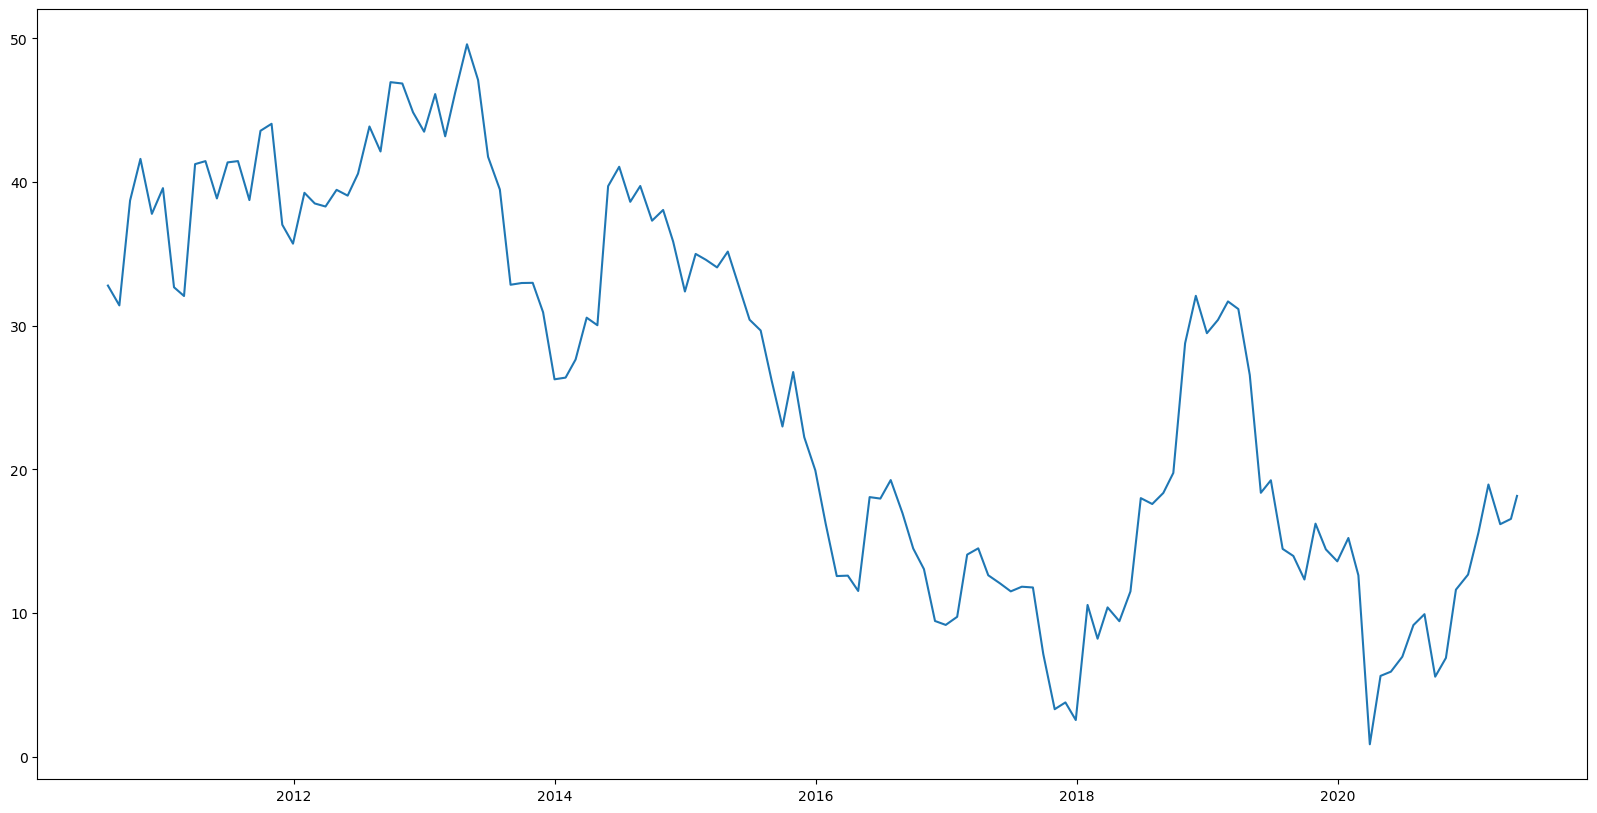

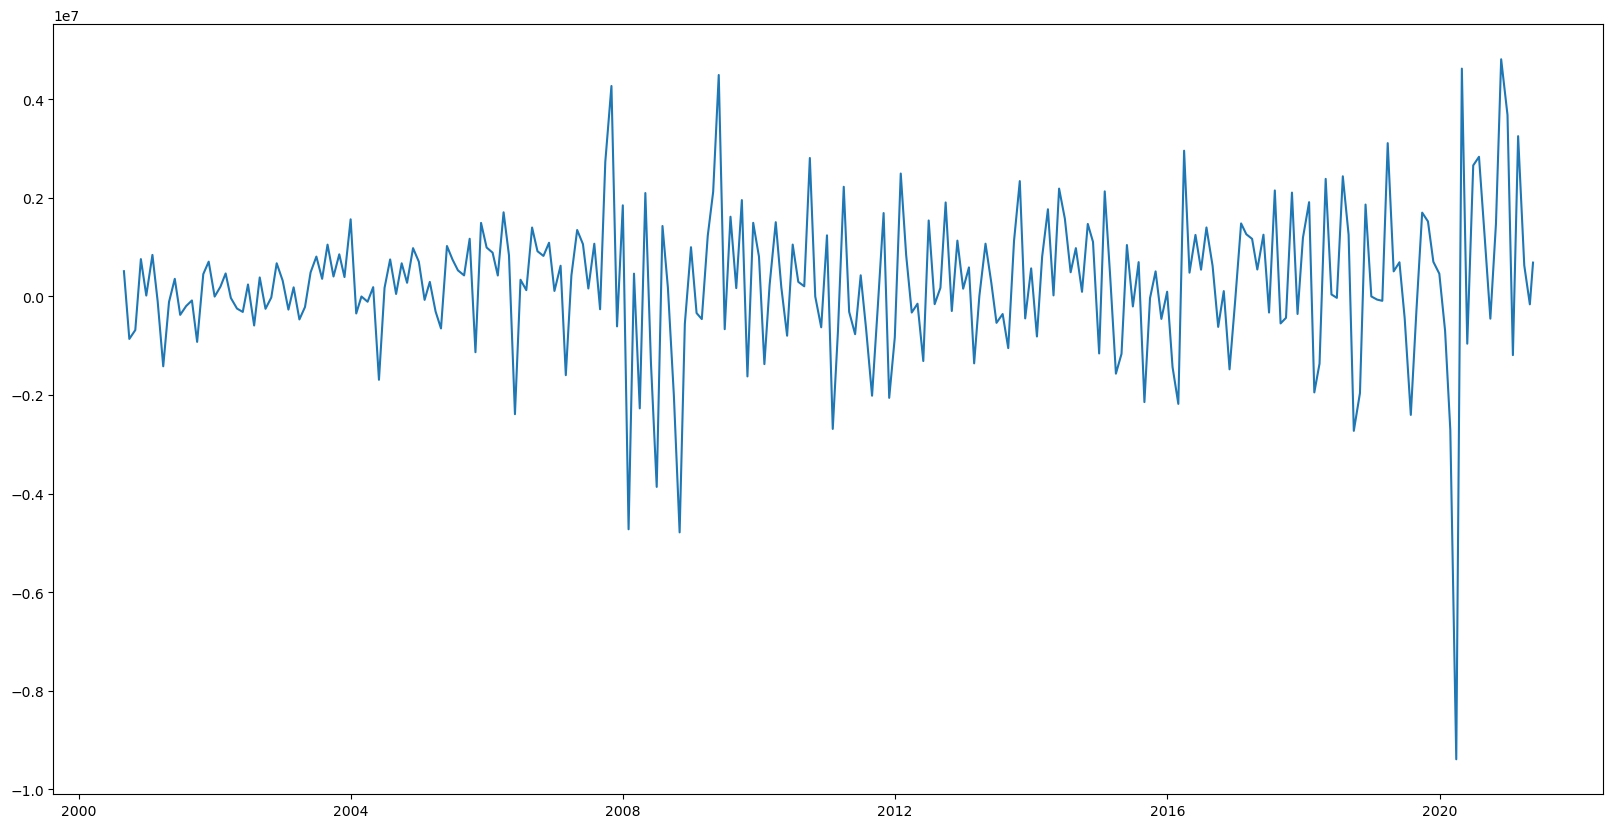

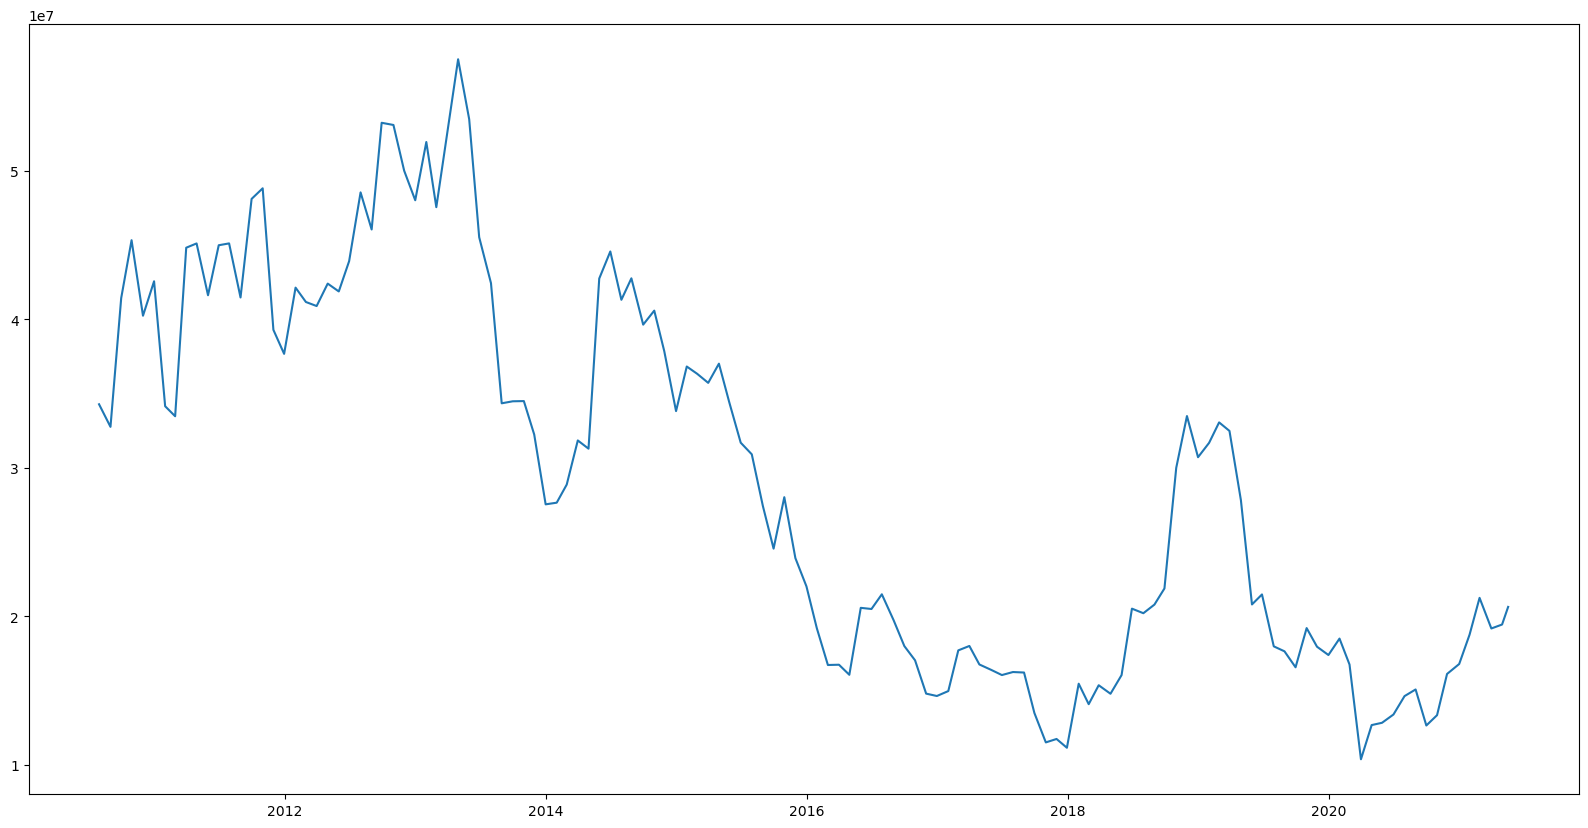

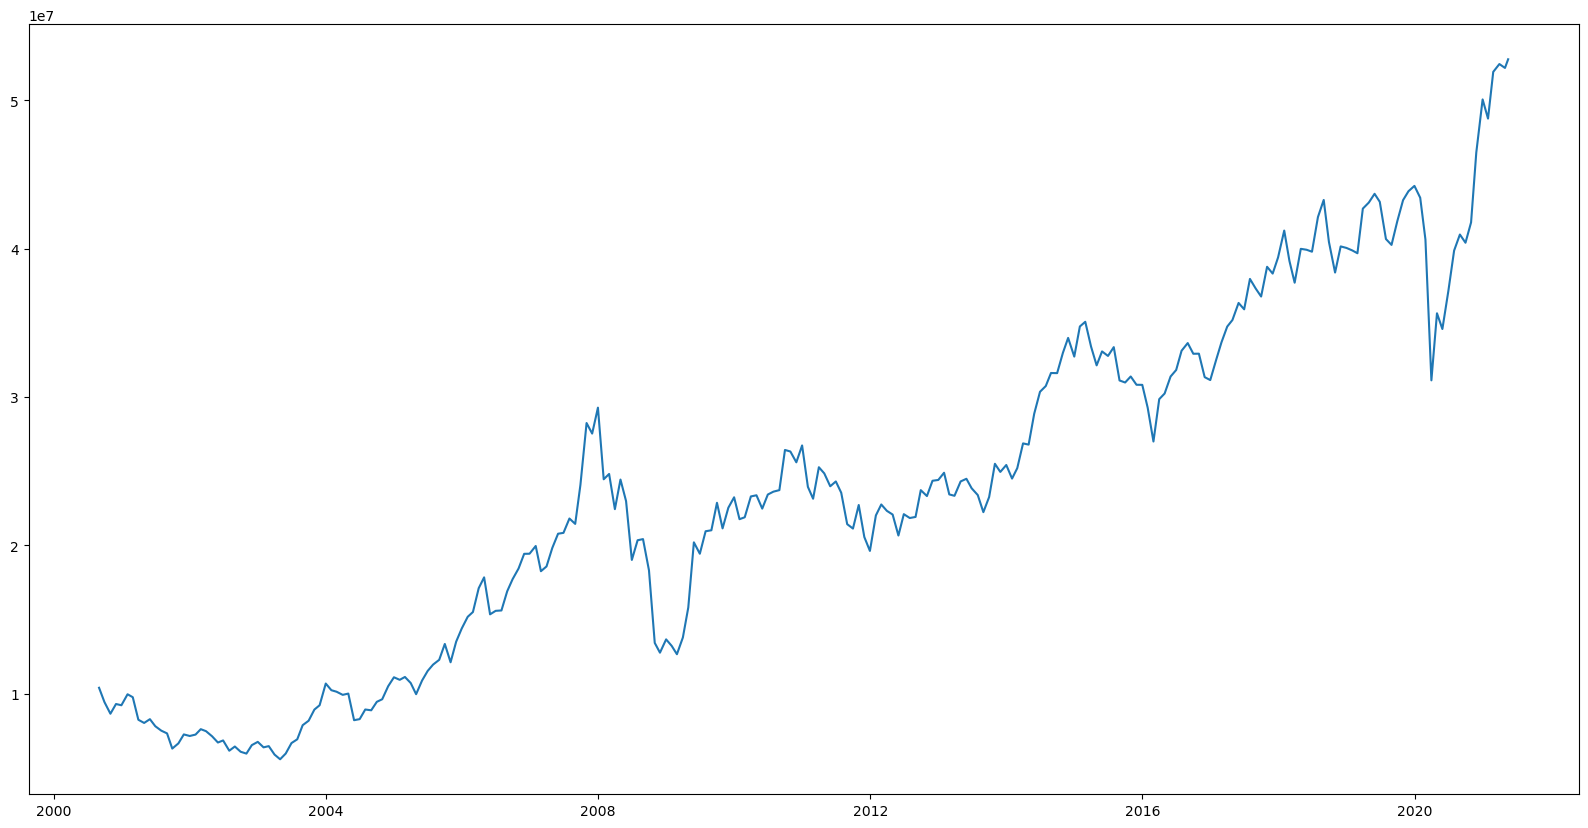

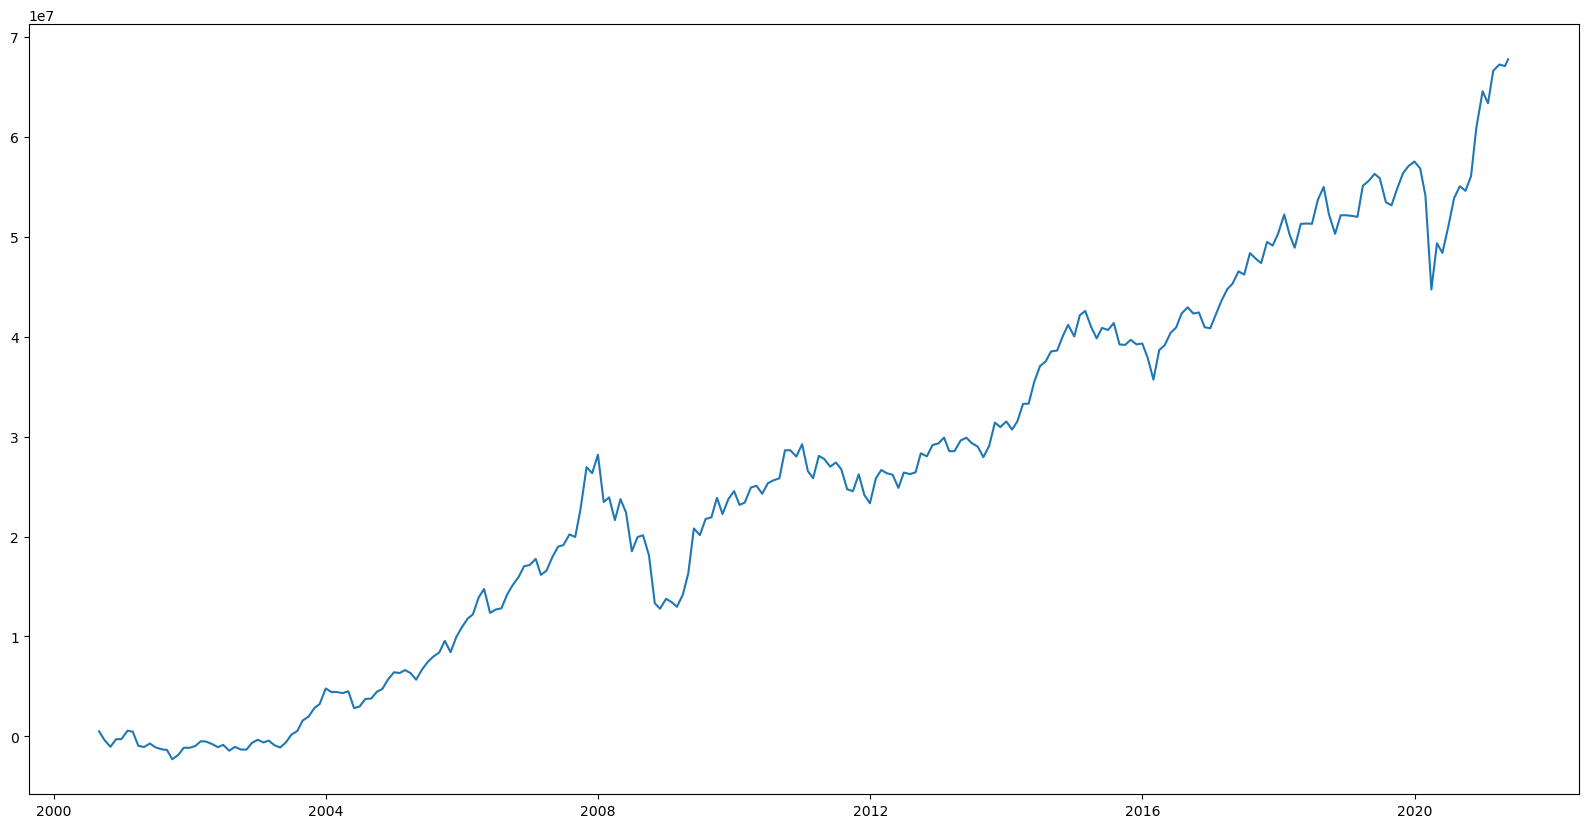

In [40]:
visualise(ten_years_onwards_IRR, 'IRR')
visualise(monthly_data, 'Monthly_Netflow')
visualise(monthly_data, 'Residual_Corpus_10_years')
visualise(monthly_data, 'Residual_Corpus_monthly')
visualise(monthly_data, 'Cummulative_Inflow')

In [45]:
ten_years_onwards_IRR.to_csv('SSWP_IRR.csv')
monthly_data.to_csv('monthly_data_SSWP.csv')

# Disciplined Systematic Withdrawal Plan 

In [46]:
monthly_data_DSWP = monthly_data[['Date','Nifty Value','PE Ratio']]
monthly_data_DSWP['10_years_%_Change'] = monthly_data_DSWP['Nifty Value'].pct_change(10*12)
monthly_data_DSWP['monthly_%_Change'] = monthly_data_DSWP['Nifty Value'].pct_change()
monthly_data_DSWP

C:\Users\Tatha\AppData\Local\Temp\ipykernel_9952\2534644088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_data_DSWP['10_years_%_Change'] = monthly_data_DSWP['Nifty Value'].pct_change(10*12)
C:\Users\Tatha\AppData\Local\Temp\ipykernel_9952\2534644088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_data_DSWP['monthly_%_Change'] = monthly_data_DSWP['Nifty Value'].pct_change()


,Date,Nifty Value,PE Ratio,10_years_%_Change,monthly_%_Change
0,2000-07-31,1332.85,17.2324,NaN,NaN
1,2000-08-31,1394.10,18.5937,NaN,0.045954
2,2000-09-29,1271.65,16.9605,NaN,-0.087834
3,2000-10-31,1172.75,15.5767,NaN,-0.077773
4,2000-11-30,1268.15,17.6839,NaN,0.081347
...,...,...,...,...,...
246,2021-01-29,13634.60,32.4338,1.476362,-0.024829
247,2021-02-26,14529.15,34.5618,1.724258,0.065609
248,2021-03-31,14690.70,31.6548,1.518226,0.011119
249,2021-04-30,14631.10,31.5140,1.544760,-0.004057


In [47]:
def find_monthly_outflow(df,interest_rate):
  for i,j in df.iterrows():
    if df.loc[i,'PE Ratio'] < 18:
      df.loc[i,'Inflow_Rate']= interest_rate * 0.5 
    elif (df.loc[i,'PE Ratio'] >= 18) & (df.loc[i,'PE Ratio'] <24):
      df.loc[i,'Inflow_Rate']= interest_rate
    elif df.loc[i,'PE Ratio'] >=24:
      df.loc[i,'Inflow_Rate']= interest_rate * 1.5
  return df

In [48]:
def DSWP_Calc_monthly(df, principal, interest_rate):
  initial_corpus = principal
  df = find_monthly_outflow(df,interest_rate)
  for i in range(1, len(df)):
    monthly_outflow = (principal * df.loc[i, 'Inflow_Rate']) / 1200
    b = ((initial_corpus*(1+ df.loc[i, 'monthly_%_Change'])))- monthly_outflow
    c = ((initial_corpus*(df.loc[i, 'monthly_%_Change'])))+ monthly_outflow
    df.loc[(i),'Residual_Corpus_monthly'] = ((initial_corpus*(1+ df.loc[i, 'monthly_%_Change'])))- monthly_outflow
    df.loc[(i),'Monthly_Netflow'] = ((initial_corpus*(df.loc[i, 'monthly_%_Change']))) + monthly_outflow
    initial_corpus = b 
    df['Cummulative_Inflow'] = df['Monthly_Netflow'].cumsum()
  return df

In [49]:
DSWP_Calc_monthly(monthly_data_DSWP,10**7, 6)

C:\Users\Tatha\AppData\Local\Temp\ipykernel_9952\2619331924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i,'Inflow_Rate']= interest_rate * 0.5
C:\Users\Tatha\AppData\Local\Temp\ipykernel_9952\628397724.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(i),'Residual_Corpus_monthly'] = ((initial_corpus*(1+ df.loc[i, 'monthly_%_Change'])))- monthly_outflow
C:\Users\Tatha\AppData\Local\Temp\ipykernel_9952\628397724.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

,Date,Nifty Value,PE Ratio,10_years_%_Change,monthly_%_Change,Inflow_Rate,Residual_Corpus_monthly,Monthly_Netflow,Cummulative_Inflow
0,2000-07-31,1332.85,17.2324,NaN,NaN,3.0,NaN,NaN,NaN
1,2000-08-31,1394.10,18.5937,NaN,0.045954,6.0,1.040954e+07,5.095416e+05,5.095416e+05
2,2000-09-29,1271.65,16.9605,NaN,-0.087834,3.0,9.470225e+06,-8.893163e+05,-3.797747e+05
3,2000-10-31,1172.75,15.5767,NaN,-0.077773,3.0,8.708698e+06,-7.115276e+05,-1.091302e+06
4,2000-11-30,1268.15,17.6839,NaN,0.081347,3.0,9.392126e+06,7.334287e+05,-3.578736e+05
...,...,...,...,...,...,...,...,...,...
246,2021-01-29,13634.60,32.4338,1.476362,-0.024829,9.0,6.844567e+07,-1.669602e+06,7.784567e+07
247,2021-02-26,14529.15,34.5618,1.724258,0.065609,9.0,7.286131e+07,4.565640e+06,8.241131e+07
248,2021-03-31,14690.70,31.6548,1.518226,0.011119,9.0,7.359646e+07,8.851469e+05,8.329646e+07
249,2021-04-30,14631.10,31.5140,1.544760,-0.004057,9.0,7.322288e+07,-2.235800e+05,8.307288e+07


In [50]:
def DSWP_Calc_10_years(df, principal, interest_rate):
  initial_corpus = principal
  ten_year_outflow = (principal*interest_rate) /10
  for i, j in df.iterrows():
    df.loc[i,'Residual_Corpus_10_years'] = (initial_corpus - ten_year_outflow) + (initial_corpus * df.loc[i, '10_years_%_Change'])
  return df

In [51]:
DSWP_Calc_10_years(monthly_data_DSWP,10**7, 6)

,Date,Nifty Value,PE Ratio,10_years_%_Change,monthly_%_Change,Inflow_Rate,Residual_Corpus_monthly,Monthly_Netflow,Cummulative_Inflow,Residual_Corpus_10_years
0,2000-07-31,1332.85,17.2324,NaN,NaN,3.0,NaN,NaN,NaN,NaN
1,2000-08-31,1394.10,18.5937,NaN,0.045954,6.0,1.040954e+07,5.095416e+05,5.095416e+05,NaN
2,2000-09-29,1271.65,16.9605,NaN,-0.087834,3.0,9.470225e+06,-8.893163e+05,-3.797747e+05,NaN
3,2000-10-31,1172.75,15.5767,NaN,-0.077773,3.0,8.708698e+06,-7.115276e+05,-1.091302e+06,NaN
4,2000-11-30,1268.15,17.6839,NaN,0.081347,3.0,9.392126e+06,7.334287e+05,-3.578736e+05,NaN
...,...,...,...,...,...,...,...,...,...,...
246,2021-01-29,13634.60,32.4338,1.476362,-0.024829,9.0,6.844567e+07,-1.669602e+06,7.784567e+07,1.876362e+07
247,2021-02-26,14529.15,34.5618,1.724258,0.065609,9.0,7.286131e+07,4.565640e+06,8.241131e+07,2.124258e+07
248,2021-03-31,14690.70,31.6548,1.518226,0.011119,9.0,7.359646e+07,8.851469e+05,8.329646e+07,1.918226e+07
249,2021-04-30,14631.10,31.5140,1.544760,-0.004057,9.0,7.322288e+07,-2.235800e+05,8.307288e+07,1.944760e+07


In [52]:
def DSWP_IRR_calculation(df, principal):
  monthly_data_new = df.iloc[120:]
  import math
  for i, k in monthly_data_new.iterrows():
    l = monthly_data_new.loc[i,'Residual_Corpus_10_years']
    m = 0.1 * (math.log((monthly_data_new.loc[i,'Residual_Corpus_10_years'])/(principal)))
    monthly_data_new.loc[i,'IRR'] = ((10**m)-1)*100
  return monthly_data_new

In [53]:
ten_years_onwards_DWSP_IRR = DSWP_IRR_calculation(monthly_data_DSWP, 10**7)

C:\Users\Tatha\AppData\Local\Temp\ipykernel_9952\1485306695.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_data_new.loc[i,'IRR'] = ((10**m)-1)*100


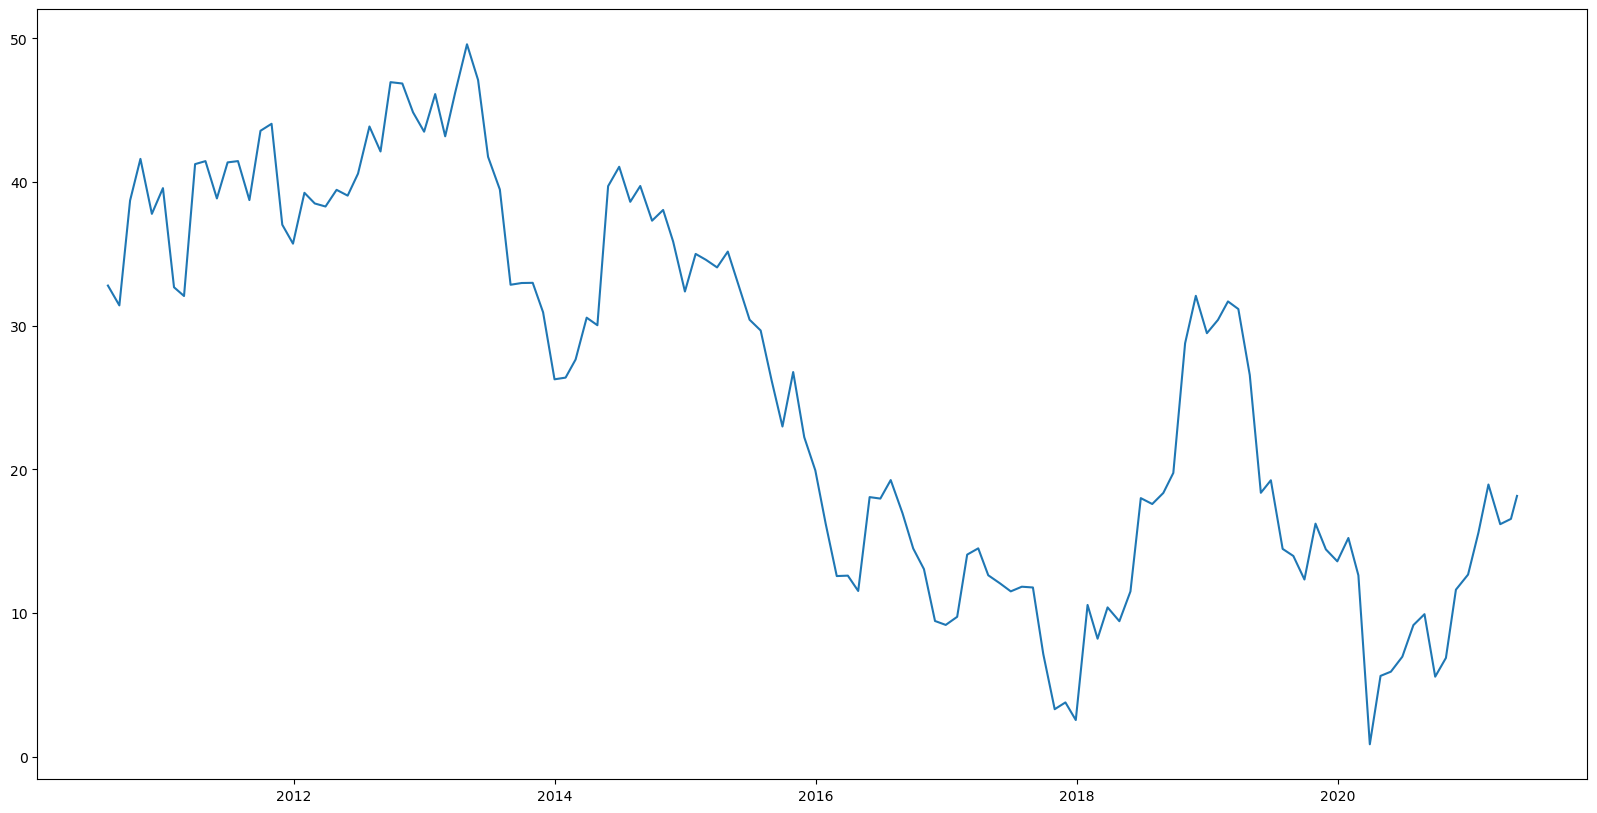

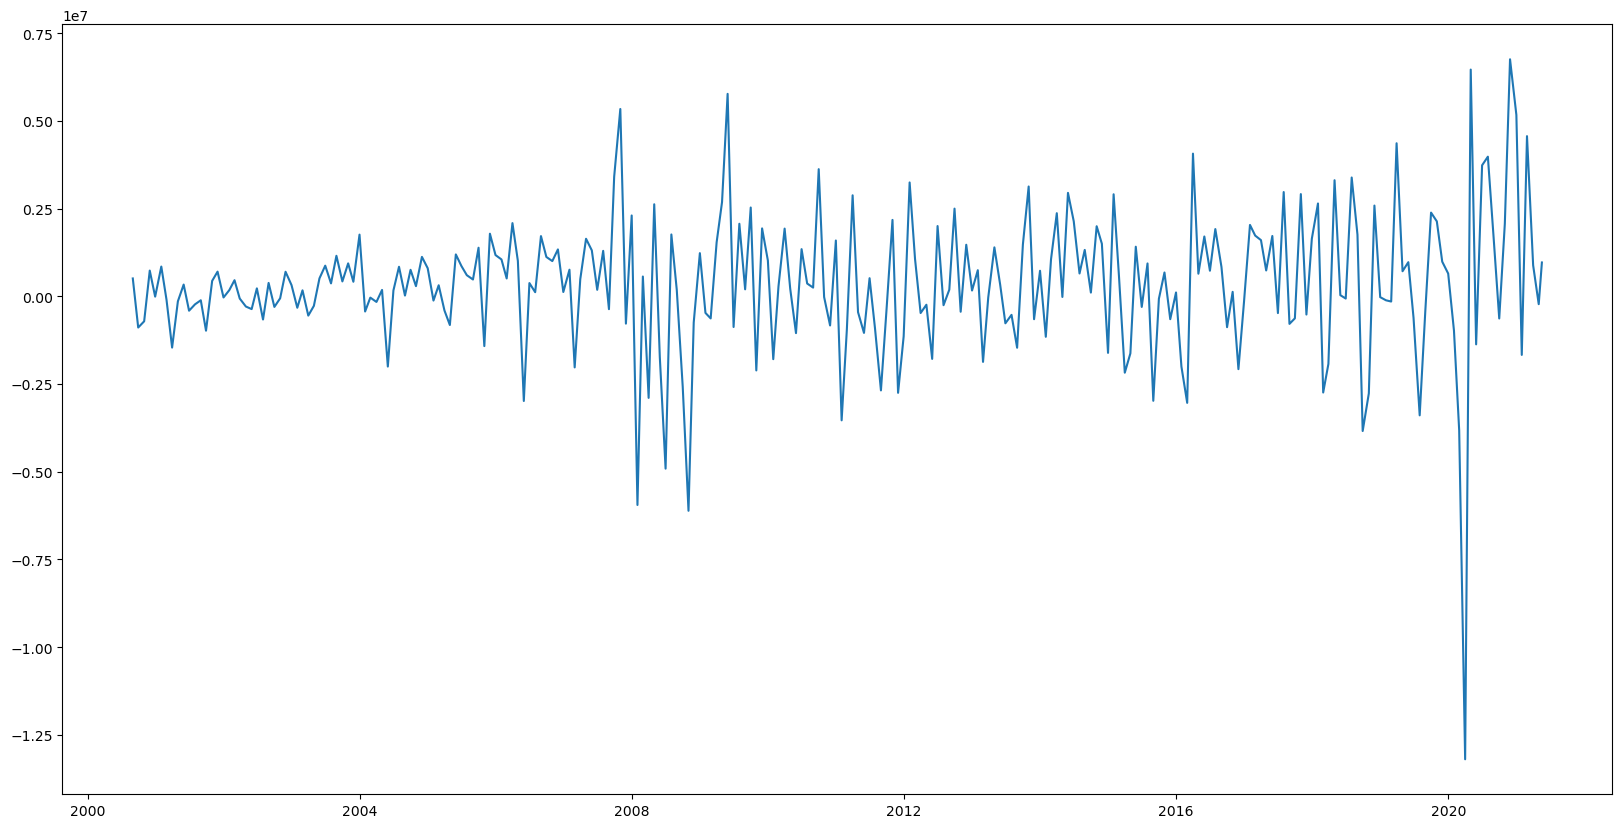

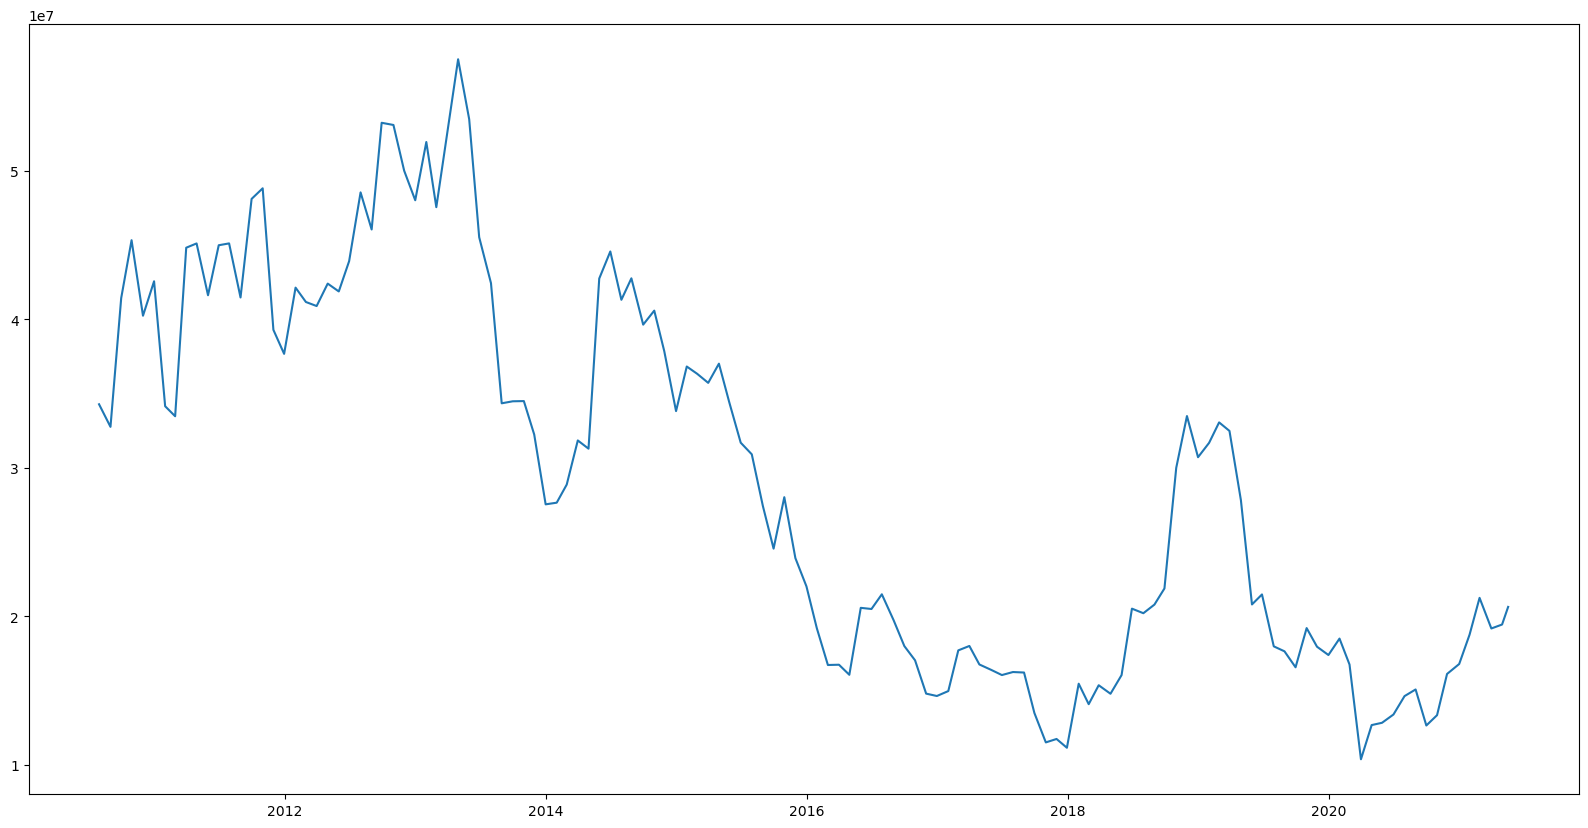

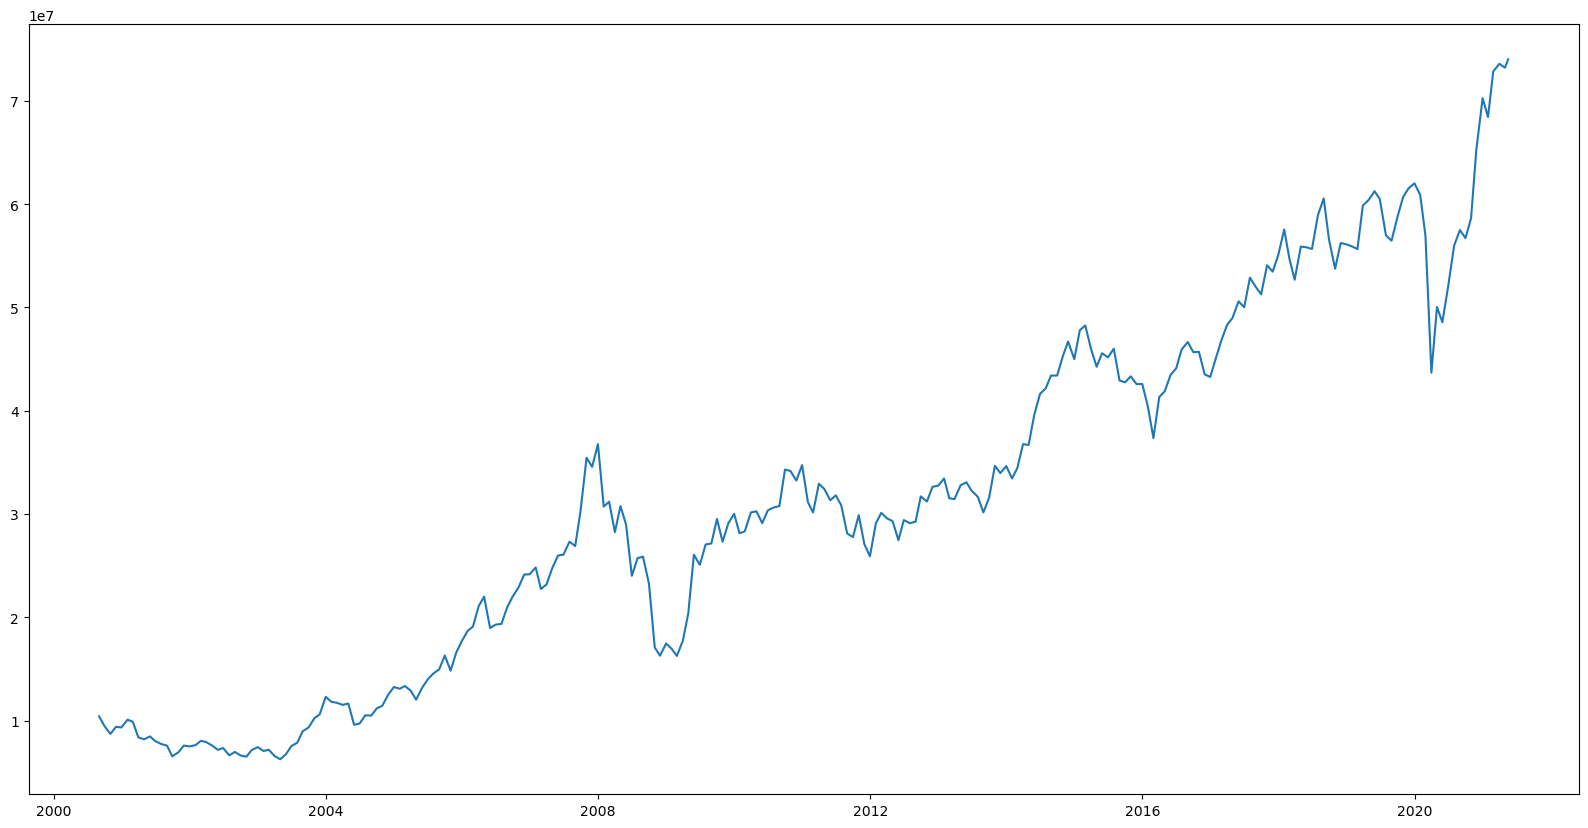

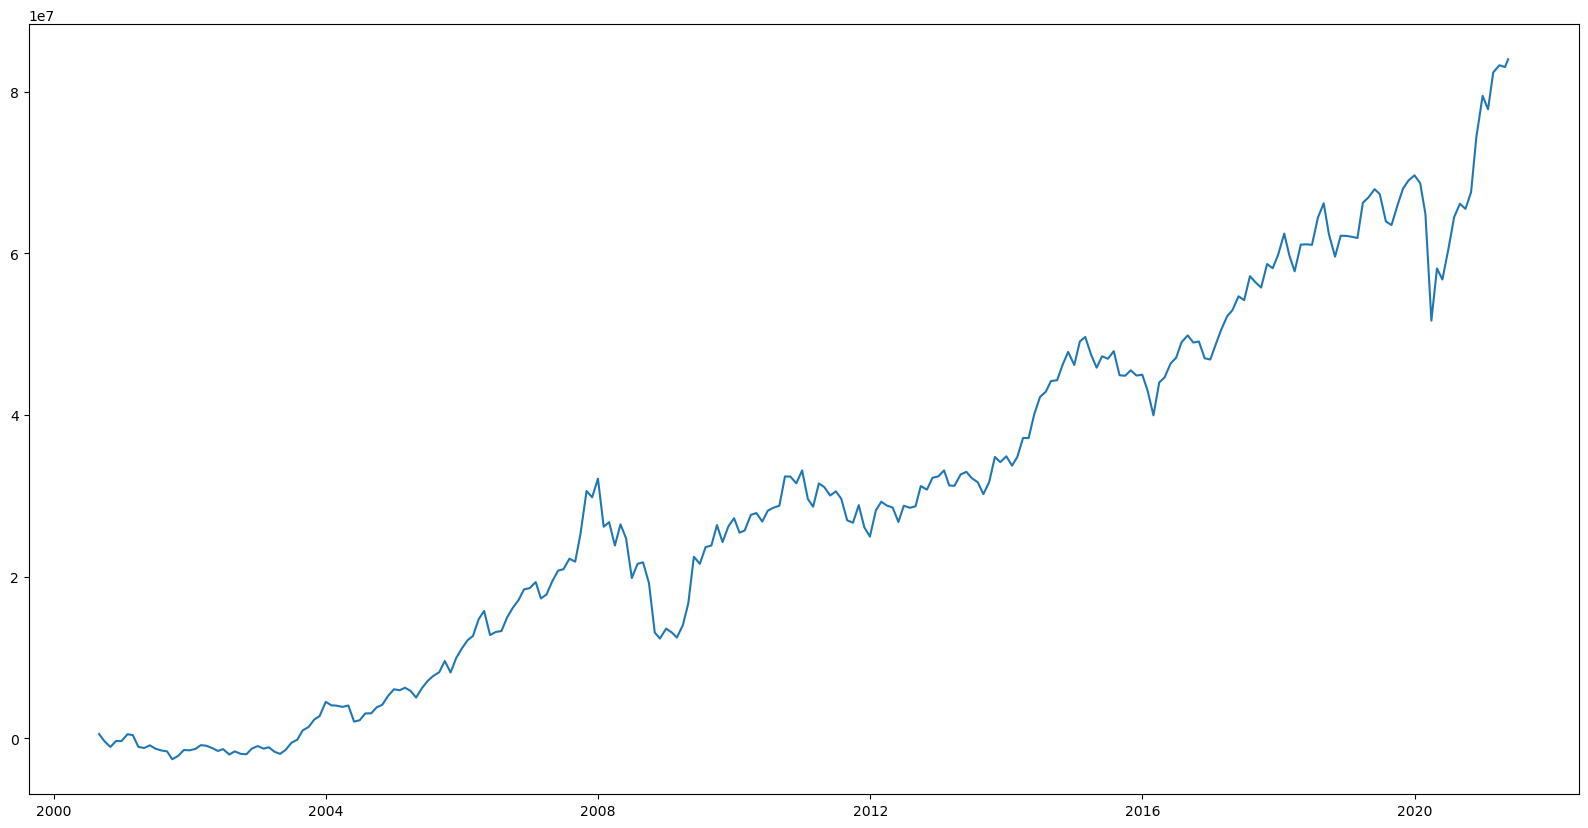

In [54]:
visualise(ten_years_onwards_DWSP_IRR, 'IRR')
visualise(monthly_data_DSWP, 'Monthly_Netflow')
visualise(monthly_data_DSWP, 'Residual_Corpus_10_years')
visualise(monthly_data_DSWP, 'Residual_Corpus_monthly')
visualise(monthly_data_DSWP, 'Cummulative_Inflow')

In [56]:
ten_years_onwards_DWSP_IRR.to_csv('DWSP_IRR.csv')
monthly_data_DSWP.to_csv('monthly_data_DSWP.csv')

**Conclusion**
I have done with my understanding of the problem. I have not used IRR formula which come after putting NPV equal to zero. Because here we are not geeting mothly fixed return. we are still getting some ammount every month but total amount which we are geeting at the end of the 10 years is not just principal amount. we are geeting return based of nifty value. that's the reason i have applied compound interest formula and calculated rate and this rate i have considered as IRR.
Note: please avoid some hard coding eg. putting numbers directly because of time constraint